<a href="https://colab.research.google.com/github/arjadre/balloon_activity/blob/main/BalloonActivityJanuary2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Preliminary stuff:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors
import urllib.request

skyblue_RGB = [0.0, 0.4, 0.9]
skyblue_hex = mplcolors.to_hex(skyblue_RGB)

In [ ]:
# Saturation vapor pressure:
def e_sat(T):
    # Calculates saturation vapor pressure, in hPa, given a temperature or temperature array in °C
    # This formula is not exact, but it is close enough for our purposes today.
    e_sat_vals = 6.112 * np.exp(17.67*T/(243.5 + T))
    return e_sat_vals

# Relative humidity:
def rel_hum(T,T_d):
    # Calculates relative humidity, in percent
    # Inputs:
    #   T = Temperature, in °C
    #   T_d = Dew point, in °C
    p_vap_actual = e_sat(T_d) # the partial pressure of water vapor
    p_vap_saturation = e_sat(T) # the saturation partial pressure of water vapor
    rh_value = 100 * p_vap_actual/p_vap_saturation
    return rh_value

In [ ]:
# Sounding info: (January 6, 2025 at 12 UTC at the OKX site, which is here in Upton, NY)
sounding_year = "25"
sounding_month = "01"
sounding_day = "06"
sounding_hour = "12"
sounding_site = "OKX"
sounding_site_name = 'Upton, NY'

# List of sites: https://www.weather.gov/upperair/sounding
# (usually need to remove the K at the beginning: KOKX on the map = OKX in the code above)
# (exception: TJSJ = San Juan, PR; do not remove the T)
# another website: https://www.spc.noaa.gov/exper/soundings/

# could also try: https://www.spc.noaa.gov/exper/soundings/24063018_OBS/TJSJ.txt - San Juan, PR at 18 UTC on June 30 2024


# URL of the data file
# This will look like: "https://www.spc.noaa.gov/exper/soundings/24062812_OBS/OKX.txt"
base_url = "https://www.spc.noaa.gov/exper/soundings/"
url = base_url + sounding_year + sounding_month + sounding_day + sounding_hour + "_OBS/" + sounding_site + ".txt"
plot_title = sounding_month + "/" + sounding_day + "/20" + sounding_year + " at " + sounding_hour + " UTC; station: " + sounding_site_name

# Function to download and parse the data
def download_and_parse(url):
    # Flags to indicate when to start and stop reading
    start_marker = "%RAW%"
    end_marker = "%END%"
    reading_data = False

    # Download the data file
    response = urllib.request.urlopen(url)
    data = response.read().decode('utf-8')

    # Split the data into lines
    lines = data.splitlines()

    # Initialize lists to store columns
    PRESSURE = []
    HGHT = []
    TEMP = []
    DWPT = []
    WDIR = []
    WSPD = []
    print(lines[5])

    # Process each line
    for line in lines:

        if line == start_marker:
            reading_data = True
            continue  # Skip processing the "%RAW%" line itself

        if reading_data:
            if line == end_marker:
                break  # Stop reading if we encounter "%END%"
            else:
                # Split the line into columns
                columns = line.split(',')

                # Convert columns to float where applicable
                level = float(columns[0].strip())
                hght = float(columns[1].strip())
                temp = float(columns[2].strip())
                dwpt = float(columns[3].strip())
                wdir = float(columns[4].strip())
                wspd = float(columns[5].strip())

                # Append to respective lists
                PRESSURE.append(level)
                HGHT.append(hght)
                TEMP.append(temp)
                DWPT.append(dwpt)
                WDIR.append(wdir)
                WSPD.append(wspd)

    # Convert lists to numpy arrays
    PRESSURE = np.array(PRESSURE)
    HGHT = np.array(HGHT)
    TEMP = np.array(TEMP)
    DWPT = np.array(DWPT)
    WDIR = np.array(WDIR)
    WSPD = np.array(WSPD)

    return PRESSURE, HGHT, TEMP, DWPT, WDIR, WSPD

# Download and parse the data
PRESSURE, HGHT, TEMP, DWPT, WDIR, WSPD = download_and_parse(url)

# Print the first few elements of each array as a check
print("PRESSURE:", PRESSURE[:5])
print("HGHT:", HGHT[:5])
print("TEMP:", TEMP[:5])
print("DWPT:", DWPT[:5])
print("WDIR:", WDIR[:5])
print("WSPD:", WSPD[:5])


%RAW%
PRESSURE: [1012. 1008. 1000.  990.  977.]
HGHT: [ 20.    52.16 117.   196.82 301.02]
TEMP: [-3.3  -2.1  -2.1  -2.7  -3.67]
DWPT: [-6.2  -8.1  -8.1  -8.7  -9.33]
WDIR: [    0. -9999.   320. -9999.   330.]
WSPD: [ 0.000e+00 -9.999e+03  8.000e+00 -9.999e+03  1.099e+01]


In [ ]:
# Now we will calculate the relative humidity:

RELHUM = rel_hum(TEMP, DWPT)


In [ ]:
# Other useful functions:

# Constants:
R_d = 287.0 # J/(kg K), gas constant for dry air
R_v = 461.5 # J/(kg K), gas constant for water vapor
eps_vapor = R_d/R_v

# Converting from Celsius to Fahrenheit:
def c2f(celsius_temp):
    fahrenheit_temp = 1.8 * celsius_temp + 32
    return fahrenheit_temp

# Converting from Fahrenheit to Celsius:
def f2c(fahrenheit_temp):
    celsius_temp = (fahrenheit_temp - 32) * (5/9)
    return celsius_temp

# Converting from Celsius to Kelvin:
def c2k(celsius_temp):
    kelvin_temp = celsius_temp + 273.15
    return kelvin_temp

# Converting from Kelvin to Celsius:
def k2c(kelvin_temp):
    celsius_temp = kelvin_temp - 273.15
    return celsius_temp

# Converting from Fahrenheit to Kelvin:
def f2k(fahrenheit_temp):
    kelvin_temp = c2k(f2c(fahrenheit_temp))
    return kelvin_temp

# Converting from Kelvin to Fahrenheit:
def k2f(kelvin_temp):
    fahrenheit_temp = c2f(k2c(kelvin_temp))
    return fahrenheit_temp

# Convert from mixing ratio (kg/kg) to specific humidity (kg/kg):
def w2q(w):
    q = w/(1+w)
    return q

# Convert from specific humidity (kg/kg) to mixing ratio (kg/kg):
def q2w(q):
    w = q/(1-q)
    return w

# Calculate virtual temperature (T_v, K) from temperature (T, K) and specific humidity (q, kg/kg):
def t2tv(T,q):
    # eps_vapor = 287.0/461.5
    T_v = (1 + (1/eps_vapor - 1)*q)*T
    return T_v

# Calculate temperature (T, K) from virtual temperature (T_v, K) and specific humidity (q, kg/kg):
def tv2t(T_v,q):
    T = T_v/(1 + (1/eps_vapor - 1)*q)
    return T

# Calculate vapor pressure (e_vap, Pa) from specific humidity (q, kg/kg) and pressure (p):
def q2e(q,p):
    e_vap = q*p/(eps_vapor - q*eps_vapor + q)
    return e_vap

# Equation of state for dry air or moist air:
def eqstate_air(flag_number,x1,x2):
    if flag_number == 1:
        # solve for p (Pa), assuming x1 = rho (kg/m^3) and x2 = T (K) or T_v (K):
        x3 = R_d*x1*x2
    elif flag_number == 2:
        # solve for T or T_v, assuming x1 = p (Pa) and x2 = rho (kg/m^3):
        x3 = x1/(R_d*x2)
    elif flag_number == 3:
        # solve for rho (kg/m^3), assuming x1 = p (Pa) and x2 = T (K) or T_v (K):
        x3 = x1/(R_d*x2)
    else:
        raise ValueError("the first input, flag_number, must equal 1, 2, or 3")
    return x3

# Equation of state for water vapor:
def eqstate_vapor(flag_number,x1,x2):
    if flag_number == 1:
        # solve for e_vap (Pa), assuming x1 = rho_v (kg/m^3) and x2 = T (K):
        x3 = R_v*x1*x2
    elif flag_number == 2:
        # solve for T (K), assuming x1 = e_vap (Pa) and x2 = rho_v (kg/m^3):
        x3 = x1/(R_v*x2)
    elif flag_number == 3:
        # solve for rho_v (kg/m^3), assuming x1 = e_vap (Pa) and x2 = T (K):
        x3 = x1/(R_v*x2)
    else:
        raise ValueError("the first input, flag_number, must equal 1, 2, or 3")
    return x3

# Supplemental for calculating q from T_v (K) and T (K):
def find_q_from_temps(T,T_v):
    q = (T_v/T - 1)/(1/eps_vapor - 1)
    return q

# Additional unit conversions:
def pa2hpa(p_Pa):
    p_hPa = p_Pa/100
    return p_hPa

def hpa2pa(p_hPa):
    p_Pa = p_hPa*100
    return p_Pa

def g2kg(x_g):
    x_kg = x_g/1000
    return x_kg

def kg2g(x_kg):
    x_g = x_kg*1000
    return x_g

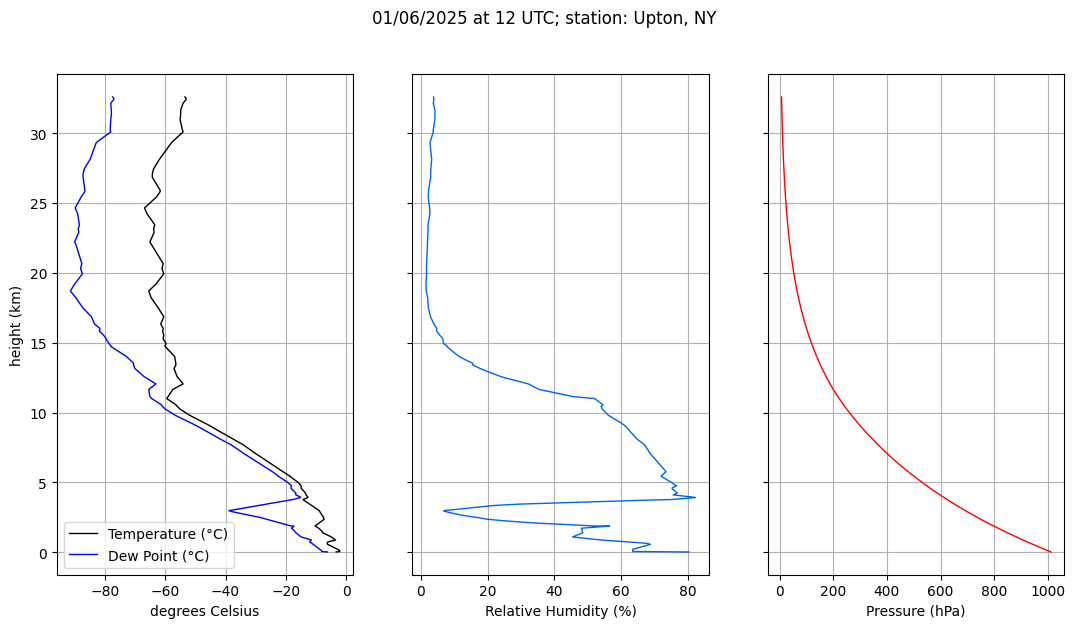

In [ ]:
HGHT_km = HGHT/1000

plt.rcParams["figure.figsize"] = [13.00, 6.50] # length, width
fig, axs = plt.subplots(1, 3, sharey=True)

# First panel:
colnow = 0
axs[colnow].plot(TEMP,HGHT_km,'k-',linewidth=1)
axs[colnow].plot(DWPT,HGHT_km,'b-',linewidth=1)
axs[colnow].legend(['Temperature (°C)','Dew Point (°C)'])
axs[colnow].set_xlabel('degrees Celsius')
axs[colnow].set_ylabel('height (km)')
#axs[colnow].set_title(plot_title)
axs[colnow].grid(True)

# Second panel:
colnow = 1
axs[colnow].plot(RELHUM,HGHT_km,linewidth=1,color=skyblue_RGB)
axs[colnow].set_xlabel('Relative Humidity (%)')
# axs[colnow].set_ylabel('height (km)')
# axs[colnow].set_title(plot_title)
axs[colnow].grid(True)

# Third panel:
colnow = 2
axs[colnow].plot(PRESSURE,HGHT_km,'r-',linewidth=1)
axs[colnow].set_xlabel('Pressure (hPa)')
# axs[colnow].set_ylabel('height (km)')
# axs[colnow].set_title(plot_title)
axs[colnow].grid(True)

fig.suptitle(plot_title)
plt.show()



%RAW%


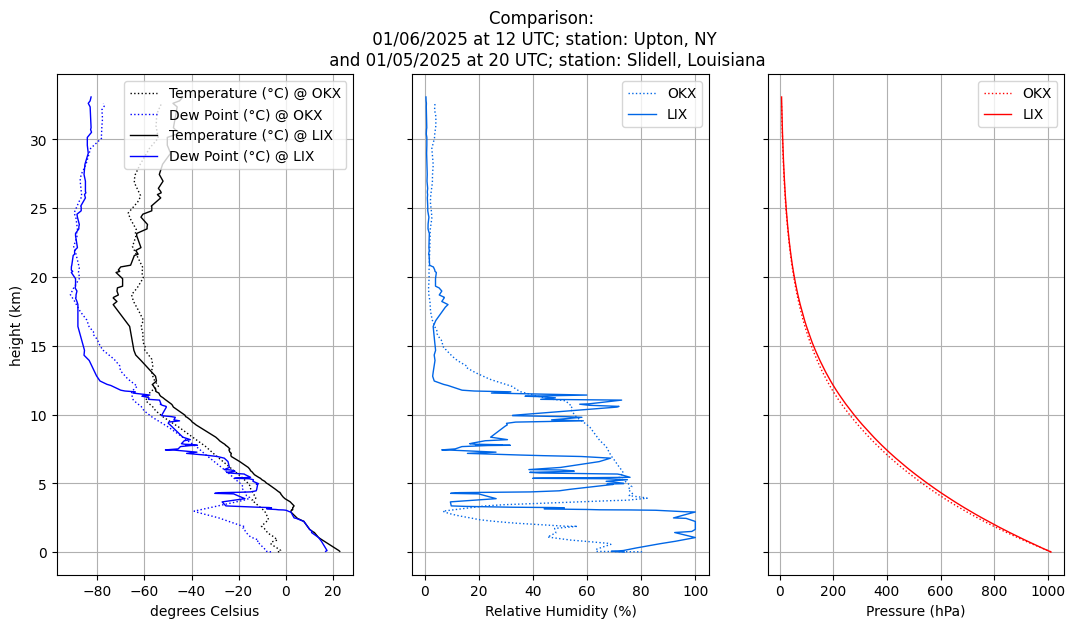

In [ ]:
# Sounding info: Tornado event

# List of sites: https://www.weather.gov/upperair/sounding
# (usually need to remove the K at the beginning: KOKX on the map = OKX in the code above)
# (exception: TJSJ = San Juan, PR; do not remove the T)
# (data from some sites outside the continental US are not available here)
# contains some errors, such as: Tucson, AZ is now KTUS instead of KTWC
# another website: https://www.spc.noaa.gov/exper/soundings/

# Note: In most cases you will want sounding_hour_2 = "00" or sounding_hour_2 = "12"
sounding_year_2 = "25"
sounding_month_2 = "01"
sounding_day_2 = "05"
sounding_hour_2 = "20"
sounding_site_2 = "LIX"
sounding_site_name_2 = 'Slidell, Louisiana'

url_2 = base_url + sounding_year_2 + sounding_month_2 + sounding_day_2 + sounding_hour_2 + "_OBS/" + sounding_site_2 + ".txt"
plot_title_2 = sounding_month_2 + "/" + sounding_day_2 + "/20" + sounding_year_2 + " at " + sounding_hour_2 + " UTC; station: " + sounding_site_name_2

# Download and parse the data
PRESSURE_2, HGHT_2, TEMP_2, DWPT_2, WDIR_2, WSPD_2 = download_and_parse(url_2)

# Relative humidity:
RELHUM_2 = rel_hum(TEMP_2, DWPT_2)

HGHT_km_2 = HGHT_2/1000

plt.rcParams["figure.figsize"] = [13.00, 6.50] # length, width
fig_2, axs_2 = plt.subplots(1, 3, sharey=True)

# First panel:
colnow = 0
axs_2[colnow].plot(TEMP,HGHT_km,'k:',linewidth=1)
axs_2[colnow].plot(DWPT,HGHT_km,'b:',linewidth=1)
axs_2[colnow].plot(TEMP_2[1:],HGHT_km_2[1:],'k-',linewidth=1)
axs_2[colnow].plot(DWPT_2[1:],HGHT_km_2[1:],'b-',linewidth=1)
axs_2[colnow].legend([('Temperature (°C) @ '+ sounding_site),('Dew Point (°C) @ ' + sounding_site), \
                   ('Temperature (°C) @ '+ sounding_site_2),('Dew Point (°C) @ ' + sounding_site_2)])
axs_2[colnow].set_xlabel('degrees Celsius')
axs_2[colnow].set_ylabel('height (km)')
#axs_2[colnow].set_title(plot_title)
axs_2[colnow].grid(True)

# Second panel:
colnow = 1
axs_2[colnow].plot(RELHUM,HGHT_km,linewidth=1,color=skyblue_RGB,linestyle='dotted')
axs_2[colnow].plot(RELHUM_2,HGHT_km_2,linewidth=1,color=skyblue_RGB)
axs_2[colnow].legend([sounding_site,sounding_site_2])
axs_2[colnow].set_xlabel('Relative Humidity (%)')
# axs_2[colnow].set_ylabel('height (km)')
# axs_2[colnow].set_title(plot_title)
axs_2[colnow].grid(True)

# Third panel:
colnow = 2
axs_2[colnow].plot(PRESSURE,HGHT_km,'r:',linewidth=1)
axs_2[colnow].plot(PRESSURE_2,HGHT_km_2,'r-',linewidth=1)
axs_2[colnow].legend([sounding_site,sounding_site_2])
axs_2[colnow].set_xlabel('Pressure (hPa)')
# axs_2[colnow].set_ylabel('height (km)')
# axs_2[colnow].set_title(plot_title)
axs_2[colnow].grid(True)

fig_2.suptitle(('Comparison: \n ' + plot_title + ' \n and ' + plot_title_2))
plt.show()


%RAW%


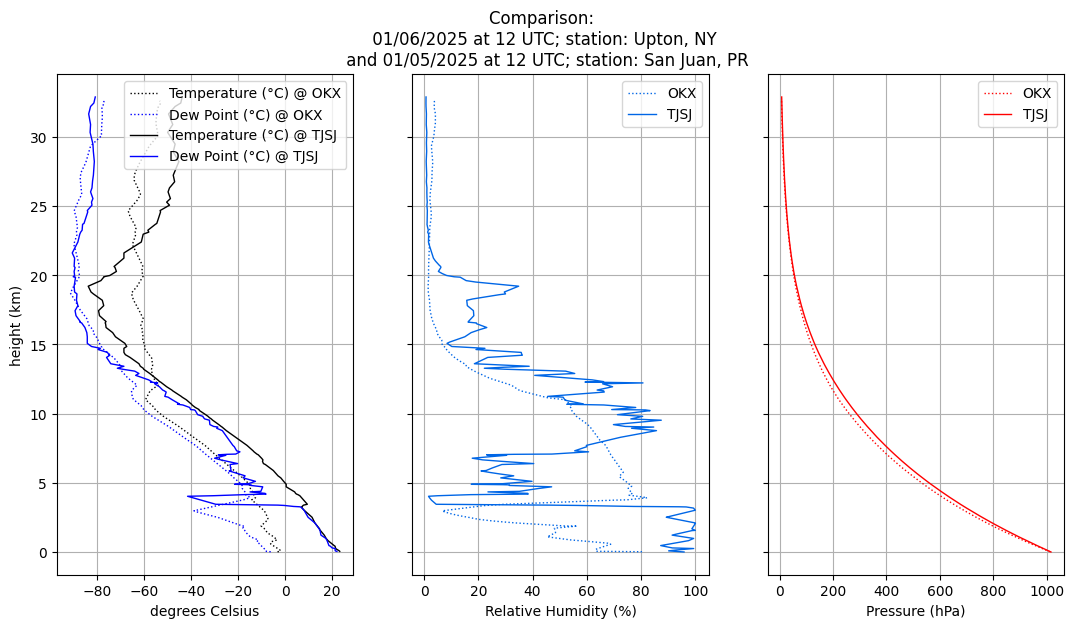

In [ ]:
# Sounding info: Choose your own!

# List of sites: https://www.weather.gov/upperair/sounding
# (usually need to remove the K at the beginning: KOKX on the map = OKX in the code above)
# (exception: TJSJ = San Juan, PR; do not remove the T)
# (data from some sites outside the continental US are not available here)
# contains some errors, such as: Tucson, AZ is now KTUS instead of KTWC
# another website: https://www.spc.noaa.gov/exper/soundings/

# Note: In most cases you will want sounding_hour_2 = "00" or sounding_hour_2 = "12"
sounding_year_2 = "25"
sounding_month_2 = "01"
sounding_day_2 = "05"
sounding_hour_2 = "12"
sounding_site_2 = "TJSJ"
sounding_site_name_2 = "San Juan, PR"

url_2 = base_url + sounding_year_2 + sounding_month_2 + sounding_day_2 + sounding_hour_2 + "_OBS/" + sounding_site_2 + ".txt"
plot_title_2 = sounding_month_2 + "/" + sounding_day_2 + "/20" + sounding_year_2 + " at " + sounding_hour_2 + " UTC; station: " + sounding_site_name_2

# Download and parse the data
PRESSURE_2, HGHT_2, TEMP_2, DWPT_2, WDIR_2, WSPD_2 = download_and_parse(url_2)

# Relative humidity:
RELHUM_2 = rel_hum(TEMP_2, DWPT_2)

HGHT_km_2 = HGHT_2/1000

plt.rcParams["figure.figsize"] = [13.00, 6.50] # length, width
fig_2, axs_2 = plt.subplots(1, 3, sharey=True)

# First panel:
colnow = 0
axs_2[colnow].plot(TEMP,HGHT_km,'k:',linewidth=1)
axs_2[colnow].plot(DWPT,HGHT_km,'b:',linewidth=1)
axs_2[colnow].plot(TEMP_2[1:],HGHT_km_2[1:],'k-',linewidth=1)
axs_2[colnow].plot(DWPT_2[1:],HGHT_km_2[1:],'b-',linewidth=1)
axs_2[colnow].legend([('Temperature (°C) @ '+ sounding_site),('Dew Point (°C) @ ' + sounding_site), \
                   ('Temperature (°C) @ '+ sounding_site_2),('Dew Point (°C) @ ' + sounding_site_2)])
axs_2[colnow].set_xlabel('degrees Celsius')
axs_2[colnow].set_ylabel('height (km)')
#axs_2[colnow].set_title(plot_title)
axs_2[colnow].grid(True)

# Second panel:
colnow = 1
axs_2[colnow].plot(RELHUM,HGHT_km,linewidth=1,color=skyblue_RGB,linestyle='dotted')
axs_2[colnow].plot(RELHUM_2,HGHT_km_2,linewidth=1,color=skyblue_RGB)
axs_2[colnow].legend([sounding_site,sounding_site_2])
axs_2[colnow].set_xlabel('Relative Humidity (%)')
# axs_2[colnow].set_ylabel('height (km)')
# axs_2[colnow].set_title(plot_title)
axs_2[colnow].grid(True)

# Third panel:
colnow = 2
axs_2[colnow].plot(PRESSURE,HGHT_km,'r:',linewidth=1)
axs_2[colnow].plot(PRESSURE_2,HGHT_km_2,'r-',linewidth=1)
axs_2[colnow].legend([sounding_site,sounding_site_2])
axs_2[colnow].set_xlabel('Pressure (hPa)')
# axs_2[colnow].set_ylabel('height (km)')
# axs_2[colnow].set_title(plot_title)
axs_2[colnow].grid(True)

fig_2.suptitle(('Comparison: \n ' + plot_title + ' \n and ' + plot_title_2))
plt.show()